In [17]:
import numpy as np
import torch
import math
!pip install gpytorch
import gpytorch
from gpytorch.kernels.rbf_kernel import postprocess_rbf
from matplotlib import pyplot as plt

from collections import OrderedDict
import copy

In [18]:

def function(X,noise=0):
  def func(x):
    return (math.pow((x[1]-5.1/(4*math.pow(3.14,2))*math.pow(x[0],2)+5/3.14*x[0]-6),2)+10*(1-1/(8*3.14))*math.cos(x[0])+10)*math.sin(x[2]/5)
  return torch.tensor(np.apply_along_axis(func, 1, X).reshape(-1,1),dtype = torch.float32)

batch_shape = torch.Size([1])
a1 = torch.linspace(-5, 10, 10)
a2 = torch.linspace(0, 15, 10)
a3 = torch.linspace(-5,5,10)
train_x = torch.zeros((10*10*10,3),dtype=torch.float32)
ctr=0
for i1 in a1:
    for i2 in a2:
        for i3 in a3:
            train_x[ctr,0] = i1
            train_x[ctr,1] = i2
            train_x[ctr,2] = i3
            ctr+=1

def get_proj_matrix(D,d,hypersphere=0):
  ''' Takes three arguments D : column size, d : row size and hypersphere = 0/1 (if hypersphere is 1 then sample each row of B from S^{D-1} else from N(0,1))
  returns a random B matrix of shape d x D '''
  A = np.random.normal(0,1,(d,D))
  if hypersphere==1:
    for row in range(d):
      N = np.linalg.norm(A[row,:])
      A[row,:] = A[row,:]/N
  return A

B = torch.tensor(get_proj_matrix(3,2,1),dtype=torch.float32)
train_x_d = (train_x @ B.t())
train_y = function(train_x)
train_y = train_y.squeeze(1)




class AleboKernel(gpytorch.kernels.Kernel):
  ''' creates instances of alebo kernel in which distance metric is mahalonobis instead of euclidean distance.'''
  def __init__(self,B):
    super().__init__(has_length=False,ard_num_dims=None,eps=0.0)
    self.d = B.shape[0]
    self.D = B.shape[1]
    self.B = B
    self.Binv = torch.pinverse(B)
    # self.dtype = B.dtype
    # self.batch_shape = batch_shape

    A = torch.qr(torch.randn(self.D,self.D))[0]
    ABinv = A[:self.d,:] @ self.Binv
    T = ABinv.t() @ ABinv
    U = torch.cholesky(T,upper = True)
    self.idx = U.nonzero().t().tolist()
    Uvec = U[self.idx]#.repeat(*batch_shape,1)
    print(Uvec)
    self.register_parameter(name = "Uvec",parameter=torch.nn.Parameter(Uvec))
    
  def forward(self,x1,x2,**params):
    U_t = torch.zeros(self.Uvec.shape[:-1]+torch.Size([self.d,self.d]))
    U_t[...,self.idx[1],self.idx[0]] = self.Uvec

    z1 = x1 @ U_t
    z2 = x2 @ U_t

    return self.covar_dist(z1,z2,square_dist=True,dist_postprocess_func=postprocess_rbf,**params)

class AleboGP(gpytorch.models.ExactGP):
  ''' Creates instance of Alebo GP by taking into account the mahalonobis kernel '''
  def __init__(self, train_x, train_y, likelihood,B):
    super().__init__(train_x, train_y, likelihood)
    self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel=AleboKernel(B=B))
    self.mean_module = gpytorch.means.ConstantMean()
  def forward(self,x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = AleboGP(train_x_d, train_y, likelihood,B)


tensor([1.3961, 0.9391, 0.9639])


In [19]:
def train(model,likelihood,train_x,train_y,training_iter=1000):
  ''' Takes model and training data and return the optimised parameter of the AleboGP model'''
# training_iter = 50
  model.train()
  likelihood.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=0.1) 

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


  for i in range(training_iter):
      optimizer.zero_grad()
      output = model(train_x)
  
      loss = -mll(output, train_y).sum()
      loss.backward()
      optimizer.step()
      params_dict = OrderedDict(mll.named_parameters())
      print(loss)

  
  model.eval()
  likelihood.eval()

  return model,likelihood

model,likelihood = train(model,likelihood,train_x_d,train_y,1000)

tensor(727.7296, grad_fn=<NegBackward>)
tensor(671.4725, grad_fn=<NegBackward>)
tensor(620.8746, grad_fn=<NegBackward>)
tensor(575.3378, grad_fn=<NegBackward>)
tensor(533.8950, grad_fn=<NegBackward>)
tensor(494.7807, grad_fn=<NegBackward>)
tensor(462.4624, grad_fn=<NegBackward>)
tensor(440.4664, grad_fn=<NegBackward>)
tensor(418.7077, grad_fn=<NegBackward>)
tensor(395.6633, grad_fn=<NegBackward>)
tensor(372.8761, grad_fn=<NegBackward>)
tensor(351.4275, grad_fn=<NegBackward>)
tensor(331.9130, grad_fn=<NegBackward>)
tensor(315.0450, grad_fn=<NegBackward>)
tensor(300.6003, grad_fn=<NegBackward>)
tensor(286.9875, grad_fn=<NegBackward>)
tensor(272.4861, grad_fn=<NegBackward>)
tensor(257.0355, grad_fn=<NegBackward>)
tensor(242.4979, grad_fn=<NegBackward>)
tensor(229.6014, grad_fn=<NegBackward>)
tensor(217.4643, grad_fn=<NegBackward>)
tensor(204.9724, grad_fn=<NegBackward>)
tensor(191.9055, grad_fn=<NegBackward>)
tensor(179.1830, grad_fn=<NegBackward>)
tensor(168.6588, grad_fn=<NegBackward>)


In [15]:
def get_r2_square(model,likelihood,train_x,train_y):
  ''' takes mode and training data and calculates r2 square score for of the model on the data'''
  observed_pred = likelihood(model(train_x))
  lower,upper = observed_pred.confidence_region()
  r2_square = 0
  sum_diff = 0
  for i in range(train_x.shape[0]):
    r2_square += (observed_pred.mean[i].detach().numpy()-train_y[i].numpy())**2
  sum_diff += np.sum(upper.detach().numpy())-np.sum(lower.detach().numpy())

  return r2_square,sum_diff
    
def get_best_fit_gp(train_x,train_y,n_trials=10):
  ''' generates and train n_trials number of models and return the model that fits the data in the best way by using r2 square metric. '''
  ## Use MLL if it gives poor result.
  best_state = {}
  r2_square = 1e9
  for i in range(n_trials):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = AleboGP(train_x, train_y, likelihood,B)

    model,likelihood = train(model,likelihood,train_x,train_y)

    r2_square_i,sum_diff_i = get_r2_square(model,likelihood,train_x,train_y)

    if r2_square_i < r2_square:
      best_state = model.state_dict()
      r2_square = r2_square_i
  
  best_likelihood =gpytorch.likelihoods.GaussianLikelihood()
  best_model = AleboGP(train_x, train_y, likelihood,B)
  best_model.state_dict(best_state)

  return best_likelihood,best_model


# def sample_U(likelihood,model,nsamp=10):
  # return list of Uvec for each model
likelihood, model = get_best_fit_gp(train_x @ B.t(),train_y)



tensor([ 0.6347, -0.7562,  0.6180])
tensor(590.4351, grad_fn=<NegBackward>)
tensor(541.4525, grad_fn=<NegBackward>)
tensor(496.7849, grad_fn=<NegBackward>)
tensor(457.3116, grad_fn=<NegBackward>)
tensor(422.8336, grad_fn=<NegBackward>)
tensor(392.1731, grad_fn=<NegBackward>)
tensor(364.7575, grad_fn=<NegBackward>)
tensor(340.7101, grad_fn=<NegBackward>)
tensor(320.2631, grad_fn=<NegBackward>)
tensor(303.1102, grad_fn=<NegBackward>)
tensor(288.2189, grad_fn=<NegBackward>)
tensor(274.6317, grad_fn=<NegBackward>)
tensor(261.9417, grad_fn=<NegBackward>)
tensor(250.1686, grad_fn=<NegBackward>)
tensor(239.5457, grad_fn=<NegBackward>)
tensor(230.1528, grad_fn=<NegBackward>)
tensor(221.8371, grad_fn=<NegBackward>)
tensor(214.3235, grad_fn=<NegBackward>)
tensor(207.3625, grad_fn=<NegBackward>)
tensor(200.8307, grad_fn=<NegBackward>)
tensor(194.6644, grad_fn=<NegBackward>)
tensor(188.9133, grad_fn=<NegBackward>)
tensor(183.6031, grad_fn=<NegBackward>)
tensor(178.7436, grad_fn=<NegBackward>)
tens

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


Streaming output truncated to the last 5000 lines.
tensor(425.6977, grad_fn=<NegBackward>)
tensor(403.9097, grad_fn=<NegBackward>)
tensor(380.8937, grad_fn=<NegBackward>)
tensor(357.3702, grad_fn=<NegBackward>)
tensor(334.9334, grad_fn=<NegBackward>)
tensor(314.5611, grad_fn=<NegBackward>)
tensor(296.2910, grad_fn=<NegBackward>)
tensor(279.6489, grad_fn=<NegBackward>)
tensor(264.3842, grad_fn=<NegBackward>)
tensor(250.4982, grad_fn=<NegBackward>)
tensor(238.0248, grad_fn=<NegBackward>)
tensor(226.9007, grad_fn=<NegBackward>)
tensor(217.0150, grad_fn=<NegBackward>)
tensor(208.2555, grad_fn=<NegBackward>)
tensor(200.5448, grad_fn=<NegBackward>)
tensor(193.7707, grad_fn=<NegBackward>)
tensor(187.8559, grad_fn=<NegBackward>)
tensor(182.5795, grad_fn=<NegBackward>)
tensor(177.7702, grad_fn=<NegBackward>)
tensor(173.2940, grad_fn=<NegBackward>)
tensor(169.1359, grad_fn=<NegBackward>)
tensor(165.2706, grad_fn=<NegBackward>)
tensor(161.6940, grad_fn=<NegBackward>)
tensor(158.3568, grad_fn=<Neg

In [75]:
def get_param_hessian(model,likelihood,x0):
  ## x0 is the model parameter at which we have to return  grad

  model.train()
  likelihood.train()

  mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
  mll = set_param(mll,x0)
  Uvev_0 = np.array([])
  for x in mll.named_parameters():
    param_name = x[0]
    # param_grad = 
  
  

/usr/local/lib/python3.7/dist-packages/gpytorch/models/exact_gp.py:275: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  GPInputWarning,


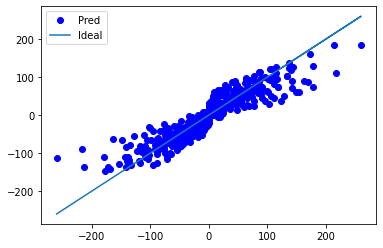

In [20]:
model.eval()
likelihood.eval()

observed_pred = likelihood(model(train_x @ B.t()))
lower,upper = observed_pred.confidence_region()


plt.plot(train_y, observed_pred.mean.detach().numpy(),'bo' ,label="Pred")
plt.plot(train_y,train_y,label='Ideal')
plt.legend()

In [21]:
def double_derivative(i,epsilon_i,m1,m2,l1,l2,train_x,train_y):
    '''Function which takes the models m1 and m2 (m2 is for m1+epsilon)
        and returns the double derivative for i-th component'''
    m1,l1 = train(m1,l1,train_x,train_y)
    m2,l2 = train(m2,l2,train_x,train_y)
    g1 = (m1.covar_module.base_kernel.Uvec.grad)
    g2 = (m2.covar_module.base_kernel.Uvec.grad)
    return (g2[i] - g1[i])/epsilon_i


def print_param(model):
  print()
  for x in model.named_parameters():
      print(x)
  print()

def update_Uvec(model,likelihood,i,ep):
  ''' updates the ith element of Uvec model parameter from Uvec[i] to Uvec[i]+ep and returns the model with updated parameters'''
  model_copy = copy.deepcopy(model)
  print_param(model_copy)
  Uvec = model_copy.covar_module.base_kernel.Uvec
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(False)
  Uvec[i] = Uvec[i]+ep
  model_copy.covar_module.base_kernel.Uvec.requires_grad_(True)
  print_param(model_copy)


def sample_U(model,likelihood,train_x,train_y,n=10):
  '''Takes best fit model and return n model where each model's Uvec is sampled from laplace approx of MAP model(model,likelihood)'''
  Uvec = model.covar_module.base_kernel.Uvec
  mean_constant = model.mean_module.constant
  output_scale = model.covar_module.raw_outputscale
  noise_covar = model.likelihood.noise_covar.raw_noise

  hessian = np.zeros((Uvec.shape[0],Uvec.shape[0]))
  ep = 1e-3 * np.abs(Uvec.detach().numpy()) + 1e-4
  for j in range(Uvec.shape[0]):
    m2,l2 = update_Uvec(model,likelihood,j,ep[j])
    hessian[i,i] = double_derivative(j,ep[j],model,m2,likelihood,l2,train_x,train_y)
  
  Sigma = np.linalg.inv(-H)
  samples = np.random.multivariate_normal(mean=Uvec.detach().numpy(), cov=Sigma, size=(n - 1))
  

  m_list = [model]
  l_list = [likelihood]

  for i in range(n-1):
    new_likelihood = gpytorch.likelihoods.GaussianLikelihood()
    new_model = AleboGP(train_x, train_y, likelihood,B)
    new_model.train()
    # Set mean constant
    new_model.mean_module.constant.requires_grad_(False)
    new_model.mean_module.constant.copy_(mean_constant)
    new_model.mean_module.constant.requires_grad_(True)

    # Set outputscale
    new_model.covar_module.raw_outputscale.requires_grad_(False)
    new_model.covar_module.raw_outputscale.copy_(output_scale)
    new_model.covar_module.raw_outputscale.requires_grad_(True)
    
    # Set noise covaiance

    new_model.likelihood.noise_covar.raw_noise.requires_grad_(False)
    new_model.likelihood.noise_covar.raw_noise.copy_(noise_covar)
    new_model.likelihood.noise_covar.raw_noise.requires_grad_(True)

    # Set Uvec 

    new_Uvec = torch.tensor(samples[i])
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)
    new_model.covar_module.base_kernel.Uvec.copy_(new_Uvec)
    new_model.covar_module.base_kernel.Uvec.requires_grad_(False)

    new_model.eval()
    new_model,new_likelihood = train(new_model,new_likelihood,train_x,train_y)

    m_list.append(new_model)
    l_list.append(new_likelihood)

  
  return m_list,l_list


def get_final_pred(models,likelihoods,test_x): # test_x is in n*d dimensions.returns means,variances
    preds = [likelihood(model(test_x @ B.t())) for likelihood,model in zip(likelihoods,models)]
    means = torch.tensor([[y.mean for y in x] for x in preds]).t()
    variances = torch.tensor([[y.variance for y in x] for x in preds]).t()
    mu = torch.mean(means,axis=1)
    variance = torch.mean(variances,axis=1) + torch.var(means,axis=1,unbiased=False)
    return mu,variance

get_final_pred([model],[likelihood],train_x[0:2,:])



# update_Uvec(model,likelihood,0,torch.tensor(1))

